<a href="https://colab.research.google.com/github/AJAkil/All-things-AI/blob/master/Practice_Domain_Adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/mnistm.py

--2023-02-16 11:43:41--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/mnistm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2659 (2.6K) [text/plain]
Saving to: ‘mnistm.py’

mnistm.py           100%[===================>]   2.60K  --.-KB/s    in 0s      

2023-02-16 11:43:42 (53.3 MB/s) - ‘mnistm.py’ saved [2659/2659]



In [ ]:
from mnistm import create_mnistm

create_mnistm()

Creating MNIST-M... That may takes a minute
Loading BSR training images


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Building train set...
Processing example 0


/content/mnistm.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bg_img = rand.choice(background_data)


Processing example 10000
Processing example 20000
Processing example 30000
Processing example 40000
Processing example 50000
Building test set...
Processing example 0
Done!


In [ ]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


In [ ]:
new = mean[:, None, None]
new.shape

torch.Size([3, 1, 1])

In [ ]:
mean.shape

torch.Size([3])

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
    transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

In [ ]:
x,y = mnist_train[0] ## tuple object
print(x.shape) # tensor: [3,28,28]
print(y) # integer label

torch.Size([3, 28, 28])
5


((x * std[:, None, None] + std[:, None, None]) * 255).permute(1, 2, 0)
Here the mean is multiplied with the three channels and then standard deviation is added to the three channels. std[:, None, None] basically unsqueezes and adds new dimensions to the stated places

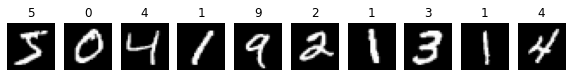

In [ ]:
## plt.subplot(row, column, index of the subplot)

plt.figure(figsize=(10, 7))

for i in range(10):
  ax = plt.subplot(1, 10, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

In [ ]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform
  
  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)


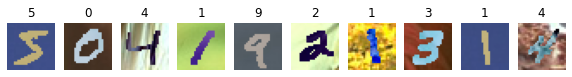

In [ ]:
## plt.subplot(row, column, index of the subplot)

plt.figure(figsize=(10, 7))

for i in range(10):
  ax = plt.subplot(1, 10, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), )
  plt.title(y)

In [ ]:
def calculate_conv_out_shape(height, width, kernel, stride, padding):
  new_width = math.floor(((width - kernel + 2 * padding)/stride) + 1)
  new_height = math.floor(((height - kernel + 2 * padding)/stride) + 1)

  return new_width, new_height



In [ ]:
w, h = calculate_conv_out_shape(28, 28, 5, 1, 2)
print(w, h)

w, h = calculate_conv_out_shape(28, 28, 2, 2, 0)
print(w, h)

28 28
14 14


In [ ]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.cnn = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, 
                                 stride=1, padding=2), # [32, 28, 28]
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # [32, 14, 14]
        torch.nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, 
                                 stride=1, padding=2), # [48, 14, 14]
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # [48, 7, 7]
    )

    
    self.linear = torch.nn.Sequential(
        torch.nn.Linear(in_features=48 * 7 * 7, out_features=100),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(in_features=100, out_features=100),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(in_features=100, out_features=10), 
    )

  def forward(self, x):
    batch_size = len(x) # it returns the first dimension/batch size
    x = self.cnn(x)
    x = x.view(batch_size, -1)
    return self.linear(x)

In [ ]:
NaiveNet()(torch.randn(2,3,28,28)).shape

torch.Size([2, 10])

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/naive.py
%pycat naive.py

--2023-02-16 11:45:01--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/naive.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 825 [text/plain]
Saving to: ‘naive.py’

naive.py            100%[===================>]     825  --.-KB/s    in 0s      

2023-02-16 11:45:01 (46.1 MB/s) - ‘naive.py’ saved [825/825]



In [ ]:
def eval_model(model, loader):
  model.eval()

  acc, loss = 0, 0.
  counter = 0
  for x, y in loader:
    counter += len(x) # adding the images within a singel batch

    with torch.no_grad():
      logits = model(x.cuda()).cpu()
    
    # accumulating both loss and accuracy
    loss += F.cross_entropy(logits, y).item()
    acc  += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / counter, 2), round(loss / len(loader), 5)

Training the model with a learning rate schedular

In [ ]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)
mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / ( 1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.0

  for x, y in source_train_loader:
    x, y = x.cuda(),  y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

Epoch 0, train loss: 0.37356
	Learning rate = 0.005946035575013606
Epoch 1, train loss: 0.05789
	Learning rate = 0.004386913376508308
Epoch 2, train loss: 0.0403
	Learning rate = 0.0035355339059327372
Epoch 3, train loss: 0.03215
	Learning rate = 0.002990697562442441
Epoch 4, train loss: 0.02715
	Learning rate = 0.0026084743001221454
Epoch 5, train loss: 0.02374
	Learning rate = 0.002323680802425408
Epoch 6, train loss: 0.02117
	Learning rate = 0.0021022410381342864
Epoch 7, train loss: 0.01917
	Learning rate = 0.0019245008972987524
Epoch 8, train loss: 0.01754
	Learning rate = 0.0017782794100389228
Epoch 9, train loss: 0.01613
	Learning rate = 0.0016556002607617019


In [ ]:
test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 0.02717, test acc: 99.1


In [ ]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.54661, test acc: 53.92


We define a gradient reversal layer by writing a custom backward in pytorch. 

To code a custom backward in PyTorch, you need to define a torch.autograd.Function.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return None.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:

In [ ]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x
  
  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors
    reversed_grad = factor * grad

    return reversed_grad, None

In [ ]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

1337.0


In [ ]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

-1337.0


Writinng the Domain Adversarial Net:

In [ ]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()

    self.cnn = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, 
                                 stride=1, padding=2), # [32, 28, 28]
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # [32, 14, 14]
        torch.nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, 
                                 stride=1, padding=2), # [48, 14, 14]
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # [48, 7, 7]
    )

    
    self.linear = torch.nn.Sequential(
        torch.nn.Linear(in_features=48 * 7 * 7, out_features=100),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(in_features=100, out_features=100),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(in_features=100, out_features=10), 
    )

    self.domain = nn.Sequential(
        nn.Linear(in_features=48 *7 * 7, out_features=100),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=100, out_features=1),
    )

    self.grl = GradientReversal.apply

  def forward(self, x, factor=1):
    batch_size = len(x) # it returns the first dimension/batch size
    x = self.cnn(x)
    x = x.view(batch_size, -1)

    class_pred = self.linear(x)
    domain_pred = self.domain(self.grl(x, -1 * factor))
    return class_pred, domain_pred

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/dann.py
%pycat dann.py

--2023-02-16 12:48:12--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/dann.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1102 (1.1K) [text/plain]
Saving to: ‘dann.py.4’

dann.py.4           100%[===================>]   1.08K  --.-KB/s    in 0s      

2023-02-16 12:48:12 (72.5 MB/s) - ‘dann.py.4’ saved [1102/1102]



In [ ]:
def eval_dann(model, loader, source=True):
  model.eval()

  clf_acc, clf_loss, dom_acc, dom_loss = 0, 0, 0, 0

  counter = 0
  
  for x, y in loader:
    counter += len(x) # adding the images within a single batch

    if source:
      d = torch.ones(len(x)) # 1 = test data of source domain
    else:
      d = torch.zeros(len(x)) # 0 = test data of target domain

    with torch.no_grad():
      cls_logits, dom_logits = model(x.cuda())
      cls_logits, dom_logits = cls_logits.cpu(), dom_logits.cpu()
    
    # accumulating both loss and accuracy for digit classifier
    clf_loss += F.cross_entropy(cls_logits, y).item()
    clf_acc  += (cls_logits.argmax(dim=1) == y).sum().item()

    # accumulating both loss and accuracy for domain classifier
    dom_loss += F.binary_cross_entropy_with_logits(dom_logits[:, 0], d).item()
    dom_acc  += ((torch.sigmoid(dom_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * clf_acc / counter, 2), round(clf_loss / len(loader), 5), round(100 * dom_acc / dom_loss, 2), round(clf_loss / len(loader), 5)

In [ ]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

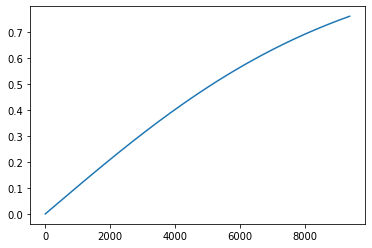

In [ ]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


### Training DANN Model

In [ ]:
epochs = 10

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)
mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / ( 1 + alpha * e / epochs) ** beta
)

lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

batch = 0 
for epoch in range(epochs):
  clf_loss, dom_loss = 0., 0.
  grl_factor = lmbd(batch) # resetted at the start of each epoch
  print(f'GRL factor: {grl_factor}')

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):

    grl_factor = lmbd(batch) # changing the value at each epoch
    batch += 1
   

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt)) # concatenating on both the example to learn features 
    # on both types of data together

    optimizer.zero_grad()
    clf_logits, dom_logits = dann(x, factor=grl_factor)
    
    # only selecting the source images for cross entropy loss
    ce = F.cross_entropy(clf_logits[:len(ys)], ys)

    """
    Tensors at the top for len(xs) have the source image and the 
    len(xt) tensors at the bottom have the target images. During training the 
    domain classifier, we are specifying the bce with such target labels that the 
    top tensors correspond to 1 for source and botton tensors correspond to 0 for
    target images. In that way the domain classifier is able to train based on 
    the type of image that it is passed on
    """
    bce = F.binary_cross_entropy_with_logits(
        dom_logits[:, 0],
        torch.cat((
            torch.ones(len(xs)),
            torch.zeros(len(xt))
        )).cuda()
    )

    loss = ce + bce
    loss.backward()
    optimizer.step()

    clf_loss += ce.item()
    dom_loss += bce.item()

  clf_loss = round(clf_loss / len(source_train_loader), 5)
  dom_loss = round(dom_loss / (2*len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {clf_loss}, domain loss: {dom_loss}')
  scheduler.step()


GRL factor: 0.0
Epoch 0, class loss: 0.24009, domain loss: 0.0717
GRL factor: 0.0996679946249559
Epoch 1, class loss: 0.04733, domain loss: 0.08289
GRL factor: 0.197375320224904
Epoch 2, class loss: 0.03673, domain loss: 0.10746
GRL factor: 0.2913126124515908
Epoch 3, class loss: 0.03664, domain loss: 0.12665
GRL factor: 0.379948962255225
Epoch 4, class loss: 0.04417, domain loss: 0.1604
GRL factor: 0.4621171572600098
Epoch 5, class loss: 0.05683, domain loss: 0.18509
GRL factor: 0.5370495669980351
Epoch 6, class loss: 0.05944, domain loss: 0.22631
GRL factor: 0.6043677771171634
Epoch 7, class loss: 0.12707, domain loss: 0.27023
GRL factor: 0.6640367702678489
Epoch 8, class loss: 0.07679, domain loss: 0.25377
GRL factor: 0.7162978701990246
Epoch 9, class loss: 0.04705, domain loss: 0.2857


In [ ]:
c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

[SOURCE] Class loss/acc: 19412.07 / 98.49%, Domain loss/acc: 0.04376 / 0.04376%
[TARGET] Class loss/acc: 9753.0 / 72.47%, Domain loss/acc: 1.47529 / 1.47529%
